In [5]:
from time import time
import pandas as pd

In [2]:
model_dir = 'code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'results_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from data_io import read_as_df
import numpy as np
from matplotlib import pyplot as plt
from data_manager import DataManager

In [3]:
batch_size=20
def extract_features(generator, sample_count, include_labels=True):
    batch_size = 20
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = generator
    i=0
    if include_labels:
        for inputs_batch, labels_batch in generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i+1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i*batch_size >= sample_count:
                break
        return features, labels
    else:
        for inputs_batch in generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i+1) * batch_size] = features_batch
            i += 1
            if i*batch_size >= sample_count:
                break
        return features

def plot_loss_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [4]:
data_dir = '../input_data'
data_name = 'microscopy'
!ls $data_dir*

microscopyCount_feat.name      microscopy_feat.name
microscopyCount_label.name     microscopy_label.name
microscopyCount_test.data      microscopy_test.data
microscopyCount_train.data     microscopy_train.data
microscopyCount_train.solution microscopy_train.solution
microscopyCount_valid.data     microscopy_valid.data


In [4]:
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file NOT found : /Users/Lawrence/Documents/MACHINE_LEARNING/DSA/input_data/microscopy_public.info
DataManager : microscopy
info:
	usage = No Info File
	name = microscopy
	format = dense
	is_sparse = 0
	has_categorical = 0
	has_missing = 0
	target_num = 1
	label_num = 2
	task = binary.classification
	target_type = Binary
	metric = auc_metric
	feat_type = Mixed
	feat_num = 4800
	train_num = 23809
	valid_num = 11893
	test_num = 12101
	time_budget = 600
data:
	X_train = array(23809, 4800)
	Y_train = array(23809,)
	X_valid = array(11893, 4800)
	Y_valid = array(0,)
	X_test = array(12101, 4800)
	Y_test = array(0,)
feat_type:	array(4800,)
feat_idx:	array(0,)



In [98]:
# dataset
X_train = D.data['X_train'][:int(23809*0.8)]
Y_train = D.data['Y_train'][:int(23809*0.8)]
validation_data = D.data['X_train'][int(23809*0.8):], D.data['Y_train'][int(23809*0.8):]

In [6]:
train_data = pd.read_csv("./train_data.csv")

In [9]:
X = train_data.drop("target",axis=1)
Y = train_data.target

In [99]:
y = Y_train
X = X_train.reshape((len(X_train), 40, 40, 3))
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)
train_generator = train_datagen.flow(X, y=y, batch_size=20,shuffle=False)
x_val, y_val = validation_data
x_val = x_val.reshape((len(x_val), 40,40,3))
val_data = (x_val, y_val)
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow(x_val, y=y_val, batch_size=20, shuffle=False)

In [100]:
X_validation = D.data['X_valid']
X_test = D.data['X_test']
validation_x  = X_validation.reshape((len(X_validation), 40,40,3))
test_x  = X_test.reshape((len(X_test), 40,40,3))
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow(validation_x,batch_size=20, shuffle=False)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator =test_datagen.flow(test_x,batch_size=20,shuffle=False)

In [90]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

In [92]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(40,40,3))
conv_base_2 = Xception(weights='imagenet',
                  include_top=False,)

83689472/83683744 [==============================] - 34s 0us/step


In [104]:
train_features, train_labels = extract_features(train_generator, len(X_train))
validation_features, validation_labels = extract_features(valid_generator, len(x_val))
# flatten extracted features to be able to feed them to a densely connected layer
train_features = np.reshape(train_features, (len(X_train), 2*2*2048))
validation_features = np.reshape(validation_features, (len(x_val), 4* 4*512))

ValueError: could not broadcast input array from shape (7,2,2,2048) into shape (20,2,2,2048)

In [96]:
# define and train densely connected classifier
model_p1 = models.Sequential()
model_p1.add(layers.Dense(512, activation='relu', input_dim=4*4*512))
model_p1.add(layers.Dense(256, activation='relu'))
model_p1.add(layers.Dropout(0.1))
model_p1.add(layers.Dense(1, activation='sigmoid'))

model_p1.compile(optimizer=optimizers.RMSprop(lr=1e-3),
                 loss='binary_crossentropy',
                 metrics=['acc'])

history_p1 = model_p1.fit(train_features, train_labels, epochs=20,
                          batch_size=20,
                          validation_data=(validation_features, validation_labels))

Train on 19047 samples, validate on 4762 samples
Epoch 1/20
19047/19047 [==============================] - 49s 3ms/sample - loss: 0.3142 - acc: 0.8900 - val_loss: 0.1538 - val_acc: 0.9471
Epoch 2/20
17240/19047 [==========================>...] - ETA: 4s - loss: 0.1904 - acc: 0.9331

KeyboardInterrupt: 

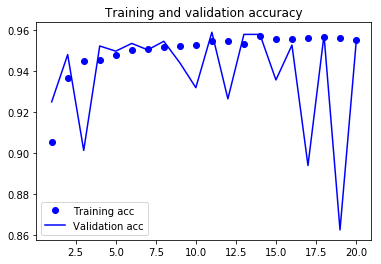

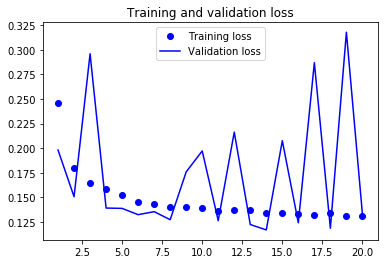

In [63]:
plot_loss_acc(history_p1)

In [43]:
test_features  = extract_features(test_generator, len(X_test), include_labels=False)
validation_features = extract_features(validation_generator, len(X_validation), include_labels=False)


In [45]:
# flatten extracted features to be able to feed them to a densely connected layer
test_features = np.reshape(test_features, (len(X_test), 4*4*512))
validation_features = np.reshape(validation_features, (len(X_validation), 4* 4*512))

In [64]:
Y_hat_train = model_p1.predict(train_features) # Optional, not really needed to test on taining examples
Y_hat_valid = model_p1.predict(validation_features)
Y_hat_test = model_p1.predict(test_features)

In [65]:
from sklearn.metrics import roc_auc_score
metric_name, scoring_function = "auc_binary", roc_auc_score
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: auc_binary


In [67]:
Y_train_full = D.data['Y_train']
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))

Training score for the auc_binary metric = 0.9918


In [71]:
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
result_name_ = result_name + "_"
!ls $result_name_*

results_submission/microscopy_test.predict
results_submission/microscopy_train.predict
results_submission/microscopy_valid.predict


In [69]:
Y_train

array([0., 0., 0., ..., 1., 1., 1.])

In [70]:
Y_hat_train

array([[9.938091e-03],
       [1.310386e-01],
       [6.515682e-04],
       ...,
       [1.000000e+00],
       [1.000000e+00],
       [1.000000e+00]], dtype=float32)

In [55]:
len(train_labels)

19047

# Test different pretrained

In [79]:
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint

In [86]:
model_1 = conv_base.output
model_1= layers.Dense(256)(model_1)
model_1 = layers.Dropout(0.3)(model_1)
predictions = layers.Dense(1, activation='sigmoid')(model_1)

In [87]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
filepath = "pre_trained_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=False, mode='min',period=1)
callbacks_list = [checkpoint,tensorboard]

model_p2 = models.Model(inputs=conv_base.input, outputs=predictions)
#model_p2.load_weights("tuned_model.h5")
model_p2.compile(optimizer=optimizers.RMSprop(lr=2e-4),
                 loss='binary_crossentropy',
                 metrics=['acc'])


W0908 20:29:38.422966 4592887232 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [89]:

history_p2 = model_p2.fit_generator(train_generator, 
                                    steps_per_epoch= len(X_train)/20,
                                    epochs=5,
                                    callbacks=callbacks_list,
                          validation_data= validation_generator,
                                    validation_steps= len(X_validation)/20,
                                   use_multiprocessing=True,
                                   workers=4)

Epoch 1/5
 28/952 [..............................] - ETA: 35:31 - loss: 0.7192 - acc: 0.4411

Process Keras_worker_ForkPoolWorker-1:
Process Keras_worker_ForkPoolWorker-2:
Process Keras_worker_ForkPoolWorker-4:
Process Keras_worker_ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python

KeyboardInterrupt: 

Process Keras_worker_ForkPoolWorker-8:
Process Keras_worker_ForkPoolWorker-7:
Process Keras_worker_ForkPoolWorker-6:
Process Keras_worker_ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/

In [ ]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
filepath = "tuned_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_best_only=False,save_weights_only=False, mode='auto',period=1)
callbacks_list = [checkpoint,tensorboard]

model_p2 = models.Model(inputs=conv_base.input, outputs=predictions)
#model_p2.load_weights("tuned_model.h5")
model_p2.compile(optimizer=optimizers.RMSprop(lr=2e-4),
                 loss='binary_crossentropy',
                 metrics=['acc'])


In [85]:

history_p2 = model_p2.fit_generator(train_generator, 
                                    steps_per_epoch= len(X_train)/20,
                                    epochs=5,
                                    callbacks=callbacks_list,
                          validation_data= validation_generator,
                                    validation_steps= len(X_validation)/20)

Epoch 1/5
 33/952 [>.............................] - ETA: 41:14 - loss: 0.9765 - acc: 0.5233

KeyboardInterrupt: 